In [1]:
# pip install pyspark

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pyspark.context import SparkContext
import pyspark
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import Evaluator

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sqlf
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct

In [5]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('first_spark_application') \
                    .getOrCreate()

In [6]:
df = spark.read.csv("C:/Users/ASUS/Downloads/application_data.csv", header=True, inferSchema=True)

In [7]:
df

DataFrame[SK_ID_CURR: int, TARGET: int, NAME_CONTRACT_TYPE: string, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, AMT_CREDIT: double, AMT_ANNUITY: double, AMT_GOODS_PRICE: double, NAME_TYPE_SUITE: string, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, REGION_POPULATION_RELATIVE: double, DAYS_BIRTH: int, DAYS_EMPLOYED: int, DAYS_REGISTRATION: double, DAYS_ID_PUBLISH: int, OWN_CAR_AGE: double, FLAG_MOBIL: int, FLAG_EMP_PHONE: int, FLAG_WORK_PHONE: int, FLAG_CONT_MOBILE: int, FLAG_PHONE: int, FLAG_EMAIL: int, OCCUPATION_TYPE: string, CNT_FAM_MEMBERS: double, REGION_RATING_CLIENT: int, REGION_RATING_CLIENT_W_CITY: int, WEEKDAY_APPR_PROCESS_START: string, HOUR_APPR_PROCESS_START: int, REG_REGION_NOT_LIVE_REGION: int, REG_REGION_NOT_WORK_REGION: int, LIVE_REGION_NOT_WORK_REGION: int, REG_CITY_NOT_LIVE_CITY: int, REG_CITY_NOT_WORK_CITY: int, LIVE_CITY_NOT_WORK_CITY

In [8]:
df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [9]:
df.show(truncate=False)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+-----------------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+----------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-

In [10]:
print('Columns overview')
col_types=pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
col_types

Columns overview


,Column Name,Data type
0,SK_ID_CURR,int
1,TARGET,int
2,NAME_CONTRACT_TYPE,string
3,CODE_GENDER,string
4,FLAG_OWN_CAR,string
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,double
118,AMT_REQ_CREDIT_BUREAU_WEEK,double
119,AMT_REQ_CREDIT_BUREAU_MON,double
120,AMT_REQ_CREDIT_BUREAU_QRT,double


In [11]:
col_types["Data type"].value_counts()

double    65
int       41
string    16
Name: Data type, dtype: int64

In [12]:
string_columns =list(col_types.loc[col_types['Data type'] == 'string', 'Column Name'].values)
numeric_columns = list(col_types.loc[col_types['Data type'] == 'int', 'Column Name'].values)
double_columns = list(col_types.loc[col_types['Data type'] == 'double', 'Column Name'].values)

In [13]:
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in double_columns:  # check zeros and NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,282686,0,0,0,0,215371,0,0,0,...,305011,307328,307355,307408,264366,264503,257456,222233,215417,71801


In [14]:
drop_list =[]

for (columnName, columnData) in missing_df.iteritems():
    #print('Column Name : ', columnName)
    if columnData.values > 500:
        drop_list.append(columnName)
drop_list

['TARGET',
 'CNT_CHILDREN',
 'NAME_TYPE_SUITE',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 

In [15]:
data = df.select([column for column in df.columns if column not in drop_list])
data = data.dropna()
len(data.columns)
df = data

In [16]:
ranked_NAME_INCOME_TYPE_df = data.select(data.NAME_INCOME_TYPE, data
                                         
                                         .AMT_CREDIT) \
    .distinct() \
    .groupBy(df.NAME_INCOME_TYPE) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 workout types
highest_NAME_INCOME_TYPE_df = ranked_NAME_INCOME_TYPE_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_NAME_INCOME_TYPE_df.rename(columns = {'count':'Credit'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_customers = ranked_NAME_INCOME_TYPE_df.groupBy().sum().collect()[0][0]

In [17]:
ranked_NAME_INCOME_TYPE_df.collect()[:5]

[Row(NAME_INCOME_TYPE='Working', count=2434),
 Row(NAME_INCOME_TYPE='Commercial associate', count=1989),
 Row(NAME_INCOME_TYPE='Pensioner', count=1111),
 Row(NAME_INCOME_TYPE='State servant', count=950),
 Row(NAME_INCOME_TYPE='Student', count=2)]

Top 5 income types that have the most count of credits:


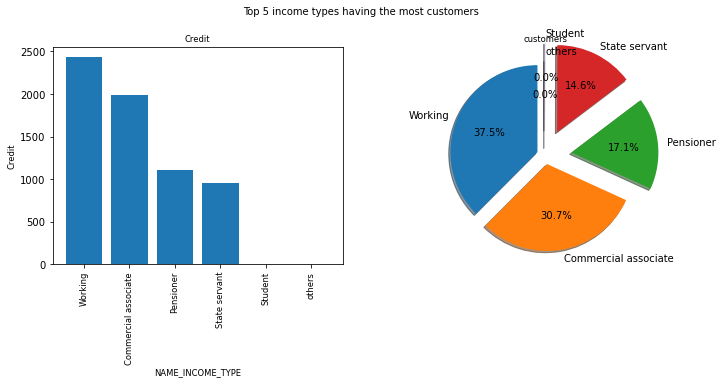

In [18]:
highest_NAME_INCOME_TYPE_df_renamed = highest_NAME_INCOME_TYPE_df
# Compute the percentage of top 5 imcome type / total customers
highest_NAME_INCOME_TYPE_df_renamed['percentage'] = highest_NAME_INCOME_TYPE_df['Credit'] \
    / total_customers * 100

# We assign the rest of users belong to another specific group that we call 'others'
others = {
      'NAME_INCOME_TYPE': 'others'
    , 'Credit': total_customers - sum(highest_NAME_INCOME_TYPE_df_renamed['Credit'])
    , 'percentage': 100 - sum(highest_NAME_INCOME_TYPE_df_renamed['percentage'])
}

highest_NAME_INCOME_TYPE_df_renamed = highest_NAME_INCOME_TYPE_df_renamed.append(
    others, ignore_index=True
)
print('Top 5 income types that have the most count of credits:')
highest_NAME_INCOME_TYPE_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_NAME_INCOME_TYPE_df_renamed['NAME_INCOME_TYPE']
                     , height=highest_NAME_INCOME_TYPE_df_renamed['Credit'])
title0 =  axs[0].set_title('Credit', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('NAME_INCOME_TYPE', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Credit', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_NAME_INCOME_TYPE_df_renamed['NAME_INCOME_TYPE'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('customers', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_NAME_INCOME_TYPE_df_renamed['percentage']
    , labels=highest_NAME_INCOME_TYPE_df_renamed['NAME_INCOME_TYPE']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 income types having the most customers', ha='center', va='top', transform=fig.transFigure)


Plot of credit counts distribution by education type:


C:\Users\ASUS\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:362: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


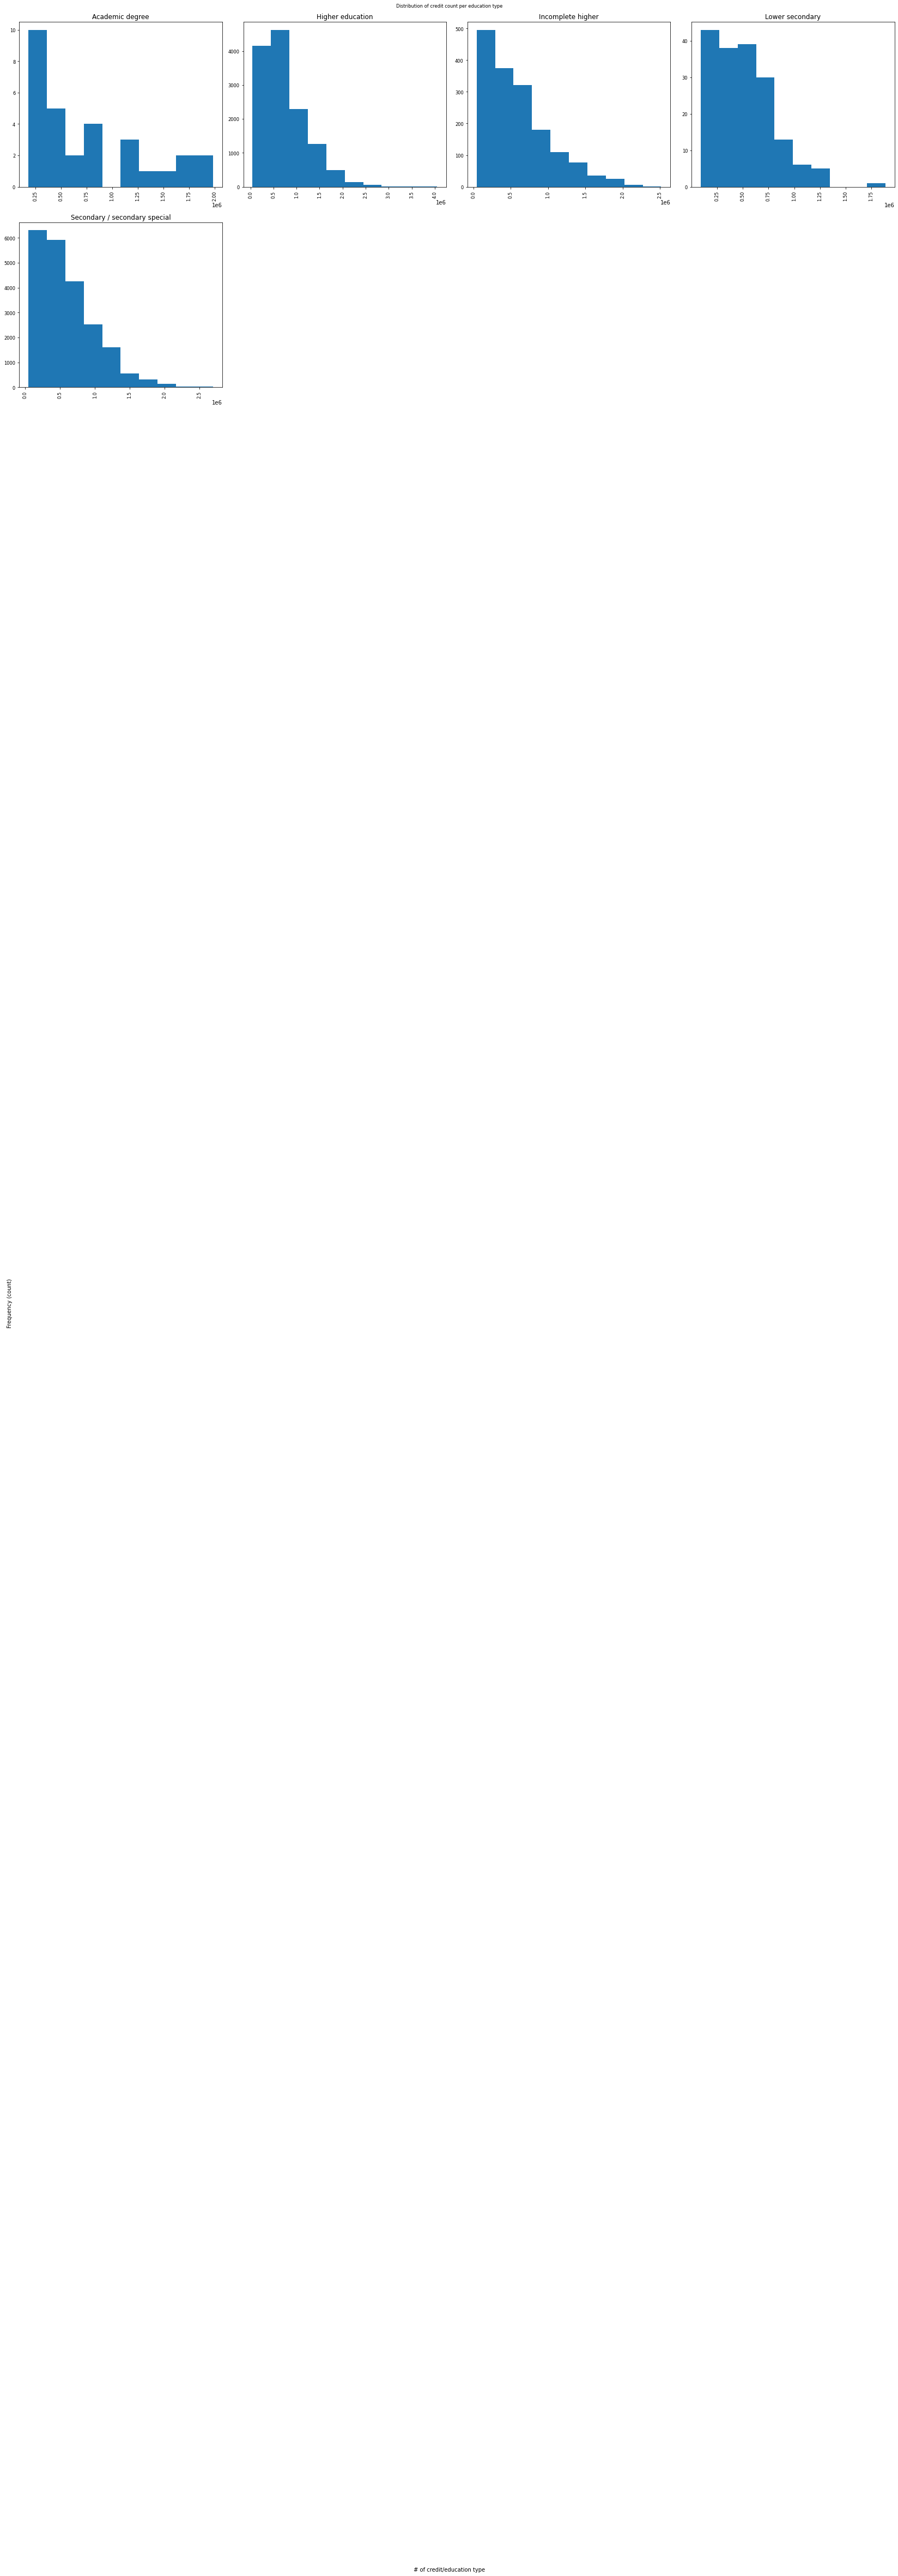

In [19]:
print('\nPlot of credit counts distribution by education type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()

PerWorkoutRecordCount_dist= data.select('AMT_CREDIT', 'NAME_EDUCATION_TYPE').toPandas().hist(
    column='AMT_CREDIT', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='NAME_EDUCATION_TYPE', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of credit count per education type', ha='center' 
         , fontsize='small', transform=fig.transFigure);
xlabel = fig.text(
    0.5, 0.01, '# of credit/education type', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

In [20]:
df = df.select('AMT_INCOME_TOTAL','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_FAMILY_STATUS'
               ,'AMT_CREDIT')

In [21]:
df.head()

Row(AMT_INCOME_TOTAL=202500.0, NAME_CONTRACT_TYPE='Cash loans', CODE_GENDER='M', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='Y', NAME_FAMILY_STATUS='Single / not married', AMT_CREDIT=406597.5)

In [22]:
df = StringIndexer(inputCol="NAME_CONTRACT_TYPE", outputCol="type_idx").fit(df).transform(df)
df = StringIndexer(inputCol="CODE_GENDER", outputCol="gender_idx").fit(df).transform(df)
df = StringIndexer(inputCol="FLAG_OWN_CAR", outputCol="car_idx").fit(df).transform(df)
df = StringIndexer(inputCol="FLAG_OWN_REALTY", outputCol="realty_idx").fit(df).transform(df)
df = StringIndexer(inputCol="NAME_FAMILY_STATUS", outputCol="NAME_FAMILY_STATUS_idx").fit(df).transform(df)

In [23]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[0,1000000, 2000000, 3000000, 4500000], inputCol="AMT_CREDIT", outputCol="AMT_CREDIT_bin")

In [24]:
df = bucketizer.transform(df)
df = df.drop('AMT_CREDIT')

In [25]:
df.head()

Row(AMT_INCOME_TOTAL=202500.0, NAME_CONTRACT_TYPE='Cash loans', CODE_GENDER='M', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='Y', NAME_FAMILY_STATUS='Single / not married', type_idx=0.0, gender_idx=1.0, car_idx=0.0, realty_idx=0.0, NAME_FAMILY_STATUS_idx=1.0, AMT_CREDIT_bin=0.0)

In [26]:
df = df.drop('NAME_CONTRACT_TYPE','CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS','AMT_CREDIT')

In [27]:
assemble = VectorAssembler(inputCols=['AMT_INCOME_TOTAL','type_idx','gender_idx', 'car_idx', 'realty_idx'
                                      ,'NAME_FAMILY_STATUS_idx'],outputCol='features')
df = assemble.transform(df)

In [28]:
df = df.drop('AMT_INCOME_TOTAL','type_idx','gender_idx', 'car_idx', 'realty_idx', 'NAME_FAMILY_STATUS_idx')

In [29]:
df.head()

Row(AMT_CREDIT_bin=0.0, features=DenseVector([202500.0, 0.0, 1.0, 0.0, 0.0, 1.0]))

In [30]:
scaler = MinMaxScaler(inputCol="features", outputCol="features1")
scalerModel = scaler.fit(df)
scaledData = scalerModel.transform(df)

In [31]:
scaledData.head()

Row(AMT_CREDIT_bin=0.0, features=DenseVector([202500.0, 0.0, 1.0, 0.0, 0.0, 1.0]), features1=DenseVector([0.0392, 0.0, 0.5, 0.0, 0.0, 0.25]))

In [32]:
scaledData = scaledData.drop('features')
scaledData.head()

Row(AMT_CREDIT_bin=0.0, features1=DenseVector([0.0392, 0.0, 0.5, 0.0, 0.0, 0.25]))

In [33]:
scaled_train, scaled_test = scaledData.randomSplit([0.8, 0.2], seed=23)

In [34]:
scaled_test.head(10)

[Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.004})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.006})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.006})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.007})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0091})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0091})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0091})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0091})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0091})),
 Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.0101}))]

In [35]:
scaled_train.head()

Row(AMT_CREDIT_bin=0.0, features1=SparseVector(6, {0: 0.004}))

In [36]:
# pipeline = Pipeline(stages=[assembler, scaler])

In [37]:
tree = DecisionTreeClassifier(labelCol='AMT_CREDIT_bin', featuresCol = 'features1')
dtparamGrid = (ParamGridBuilder()
             .addGrid(tree.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(tree.maxBins, [10, 20, 40, 80, 100])
             .build())
accuracy_eval = MulticlassClassificationEvaluator(metricName='accuracy', labelCol='AMT_CREDIT_bin')
precision_eval = MulticlassClassificationEvaluator(metricName='weightedPrecision', labelCol='AMT_CREDIT_bin')
recall_eval = MulticlassClassificationEvaluator(metricName='weightedRecall', labelCol='AMT_CREDIT_bin')

In [38]:
dtcv = CrossValidator(estimator = tree,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = accuracy_eval,
                      numFolds = 5)

In [39]:
dtcvModel = dtcv.fit(scaled_train)
dtpredictions = dtcvModel.transform(scaled_test)

In [40]:
print('dtc accuracy:')
print(accuracy_eval.evaluate(dtpredictions))
print('DTC precision:')
print(precision_eval.evaluate(dtpredictions))
print('DTC recall:')
print(recall_eval.evaluate(dtpredictions))

dtc accuracy:
0.8045930153553472
DTC precision:
0.7418349811643836
DTC recall:
0.8045930153553472
